このNotebookは、モデルを学習させるために作られたものである。

# 1. Configuration

In [262]:
# Run Configuration
NOTEBOOK_NAME = "swin-s-base-512x16"
SAVE_DIR = "../results/" + NOTEBOOK_NAME
TEST_RUN = True
SEED = 42
DEVICE = 'cuda'

# Weights & Biases Configuration
USE_WANDB = False
WANDB_INIT = {
    'project': 'RSNA-IAD',
    'group': 'Image Classification',
    'job_type': 'training_Swin_s',
}
ARTIFACT = {
    'name': NOTEBOOK_NAME,
    'type': 'loss & time',
}

# Input Data Configuration
IMAGE_SIZE = 256
NUM_SLICES = 16
BATCH_SIZE = 5
NUM_EPOCHS = 20
LABEL_NAMES = [
    # 13 classes
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    # 'Aneurysm Present',
]


In [263]:
class Configuration:
    
    notebook_name = NOTEBOOK_NAME
    save_dir = SAVE_DIR
    test_run = TEST_RUN
    seed = SEED
    device = DEVICE
    use_wandb = USE_WANDB
    wandb_init = WANDB_INIT
    artifact = ARTIFACT
    image_size = IMAGE_SIZE
    num_slices = NUM_SLICES
    batch_size = BATCH_SIZE
    num_epochs = NUM_EPOCHS
    label_names = LABEL_NAMES

CFG = Configuration


# 2. Import

In [264]:
import os
import random
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Optional, Tuple
from IPython.display import display
import datetime
import time
from tqdm.notebook import tqdm

# Data handling
import numpy as np
import polars as pl
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split

# Medical imaging
import pydicom
import cv2

# Machine Lerning 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast
import torchvision
import timm

# Transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image

# Experiment Management
import wandb

# Competition API
# import kaggle_evaluation.rsna_inference_server


In [265]:
# datetime for unique checkpoint filenames
date_time = datetime.datetime.now()
date_time = date_time.strftime('%Y-%m-%d_%H-%M-%S')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [266]:
def set_random_seeds(seed=CFG.seed, deterministic=False):

    """
    Set random seed.
    
    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: False.
    """
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    if deterministic:
        torch.backends.cudnn.benchmark = True

set_random_seeds(seed=CFG.seed, deterministic=True)


# 3. Weights & Biases

In [267]:
if CFG.use_wandb:

    os.environ['WANDB_NOTEBOOK_NAME'] = CFG['notebook_name']
    wandb.login()
    run = wandb.init(**CFG.wandb_init)
    artifact = wandb.Artifact(**CFG.artifact)

else:
    
    run = None
    artifact = None


In [268]:
def alert_by_wandb(title='', text=''):
    wandb.alert(title, text)


# 4. Model

In [269]:
# Model
# https://docs.pytorch.org/vision/main/models/generated/torchvision.models.swin_s.html#torchvision.models.Swin_S_Weights

model = torchvision.models.swin_s(pretrained=False, num_classes=13)
model.features[0][0] = nn.Conv2d(
    in_channels=CFG.num_slices,
    out_channels=96,
    kernel_size=4,
    stride=4,
    padding=0
)
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters())

# Loss Function
criterion = nn.BCEWithLogitsLoss()

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CFG.num_epochs
)


In [270]:
is_in_cuda_list = []

for name, parameter in model.named_parameters():
    # determination of cuda and its storage
    is_in_cuda_list.append(parameter.is_cuda)
    
if all(is_in_cuda_list):
    print('All parameters is in cuda')
        
else:
    print('One of the parameters is not in the cuda.')


All parameters is in cuda


# 5. Dataset

In [271]:
series_list = os.listdir(f'../series_npy/{CFG.image_size}')
image_path_df = pd.read_csv(f'../npy_path/image_{CFG.image_size}_path_df.csv')
label_df = pd.read_csv(f'../train.csv')
label_df = label_df[['SeriesInstanceUID'] + CFG.label_names]
image_path_df


,series_id,npy_path
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,../series_npy/256/1.2.826.0.1.3680043.8.498.10...
1,1.2.826.0.1.3680043.8.498.10004044428023505108...,../series_npy/256/1.2.826.0.1.3680043.8.498.10...
2,1.2.826.0.1.3680043.8.498.10004044428023505108...,../series_npy/256/1.2.826.0.1.3680043.8.498.10...
3,1.2.826.0.1.3680043.8.498.10004044428023505108...,../series_npy/256/1.2.826.0.1.3680043.8.498.10...
4,1.2.826.0.1.3680043.8.498.10004044428023505108...,../series_npy/256/1.2.826.0.1.3680043.8.498.10...
...,...,...
1001301,1.2.826.0.1.3680043.8.498.99985209798463601651...,../series_npy/256/1.2.826.0.1.3680043.8.498.99...
1001302,1.2.826.0.1.3680043.8.498.99985209798463601651...,../series_npy/256/1.2.826.0.1.3680043.8.498.99...
1001303,1.2.826.0.1.3680043.8.498.99985209798463601651...,../series_npy/256/1.2.826.0.1.3680043.8.498.99...
1001304,1.2.826.0.1.3680043.8.498.99985209798463601651...,../series_npy/256/1.2.826.0.1.3680043.8.498.99...


In [272]:
def minmax_scaling(images: torch.Tensor) -> torch.Tensor:
    
    if torch.max(images) > 1.0:
        
        images = images / 255
        
    return images


In [273]:
# for training
train_transform = A.Compose(
    [
        # # Elastic Transform
        # A.ElasticTransform( p=0.5),
        
        # Rotation
        A.Rotate(limit=15, p=0.5, seed=CFG.seed),
        
        # Normalization
        A.Normalize(normalization='min_max'),
        
        # ToTensor
        ToTensorV2(),
    ]
)

# for inference
inference_transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
)
    
# for TTA
tta_transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            
        # Horizontal flip
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        # Vertical flip
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        # 90 degree rotation
        A.RandomRotate90(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        # ↓ Original
        # Sharpen
        A.Sharpen(alpha=(0, 1.0), p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        ToTensorV2(),
    ]
)


In [274]:
class BaseDataset(torch.utils.data.Dataset):
    '''
    Datasetの__getitem__()は、num_slicesの枚数分だけ画像を出力する。
    
    Arguments:
    - series_list: 画像のSeriesInstanceUIDのリスト
    - image_path_df: 画像のパスを含むDataFrame
    - label_df: ラベルが入ったDataFrame
    - num_slices: 1つのシリーズから抽出するスライス数
    - transforms: 画像変換のためのAlbumentationsのComposeオブジェクト
    '''
    def __init__(self,
                 series_list: list,
                 image_path_df: pd.DataFrame,
                 label_df: pd.DataFrame,
                 transforms=None
        ):
        self.series_list = series_list
        self.image_path_df = image_path_df
        self.label_df = label_df
        self.transforms = transforms
        self.num_slices = CFG.num_slices

    def __len__(self):
        return len(self.series_list)

    def __getitem__(self, index):
        # Index to SeriesInstanceUID
        series_id = self.series_list[index]
        print(series_id)
        # SeriesInstanceUID to Image Path
        image_path_df = self.image_path_df[
            self.image_path_df['series_id'] == series_id
        ].reset_index(drop=True)
        
        # Load Images
        indices = np.linspace(0,
                              len(image_path_df) - 1,
                              self.num_slices).astype(np.int32)
        # Stack images to (H, W, CFG.num_slices)
        images = []
        for i in indices:
            image_path = image_path_df.loc[i, 'npy_path']
            image = np.load(image_path).astype(np.uint8)
            images.append(image)
        images = np.stack(images, axis=-1)
        
        # Transform
        if self.transforms:
            # ToTensorV2はnumpy.ndarrayをtorch.Tensorに変換する
            augmented = self.transforms(image=images)
            images = augmented['image']
        else:
            images = torch.tensor(images, dtype=torch.float32)
            images = torch.permute(images, (2, 0, 1))
            # Normlization
            if torch.max(images) > 1.0:
                images = images / 255

        # Labels
        labels = self.label_df.loc[series_id, CFG.label_names].values
        labels = torch.tensor(labels, dtype=torch.float32)
        
        return (images, labels)


# 6. DataLoader

In [275]:
def build_dataloaders():

    series = label_df[["SeriesInstanceUID"]].values
    labels = label_df[CFG.label_names].values

    if CFG.test_run:
        # As the absolute number of data points cannot be specified,
        # split is executed in two stages.
        train_series, train_labels, val_series, _ = iterative_train_test_split(
            series, labels, test_size=(1/len(series)) \
                * 2
        )
        _, _, train_series, train_labels = iterative_train_test_split(
            train_series, train_labels, test_size=(1/len(series)) \
                * 2
        )
        
    else:
        train_series, train_labels, val_series, val_labels = iterative_train_test_split(
            series, labels, test_size=0.2
        )

    # 2 dimensions -> 1 dimension
    train_series, val_series = train_series.flatten(), val_series.flatten()
    # train_series = [
        # '1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557',
        # '1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557'
    # ]
    print(f"Train size: {len(train_series)}, Val size: {len(val_series)}")

    train_image_path_df = \
        image_path_df[image_path_df['series_id'] \
        .isin(train_series)].reset_index(drop=True)
    val_image_path_df = \
        image_path_df[image_path_df['series_id'] \
        .isin(val_series)].reset_index(drop=True)
        
    train_label_df = label_df[label_df['SeriesInstanceUID']
        .isin(train_series)].set_index('SeriesInstanceUID')
    val_label_df = label_df[label_df['SeriesInstanceUID']
        .isin(val_series)].set_index('SeriesInstanceUID')

    train_dataset = BaseDataset(
        series_list=train_series,
        image_path_df=train_image_path_df,
        label_df=train_label_df,
        transforms=train_transform
    )
    val_dataset = BaseDataset(
        series_list=val_series,
        image_path_df=val_image_path_df,
        label_df=val_label_df,
        transforms=train_transform # tta_transform
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=0
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=0
    )

    return train_dataset, train_dataloader, val_dataloader


In [276]:
train_dataset, train_dataloader, val_dataloader = build_dataloaders()


Train size: 2, Val size: 2


[  0.         2.540039   5.080078   7.620117  10.160156  12.700195
  15.240234  17.780273  20.320312  22.860352  25.40039   27.94043
  30.480469  33.020508  35.560547  38.100586  40.640625  43.180664
  45.720703  48.260742  50.80078   53.34082   55.88086   58.4209
  60.960938  63.500977  63.75      66.041016  66.29004   68.581055
  68.83008   71.12109   71.37012   73.66113   73.91016   76.20117
  76.450195  78.74121   78.990234  81.28125   81.53027   83.82129
  84.07031   86.36133   86.61035   88.90137   89.15039   91.44141
  91.69043   93.981445  94.23047   96.521484  96.77051   99.06152
  99.31055  101.60156  101.850586 104.1416   104.390625 106.68164
 106.930664 109.22168  109.4707   111.76172  112.01074  114.30176
 114.55078  116.8418   117.09082  119.381836 119.63086  121.921875
 122.1709   124.461914 124.71094  127.00195  127.25098  127.5
 129.54199  129.79102  130.04004  132.08203  132.33105  132.58008
 134.62207  134.8711   135.12012  137.16211  137.41113  137.66016
 139.70215 

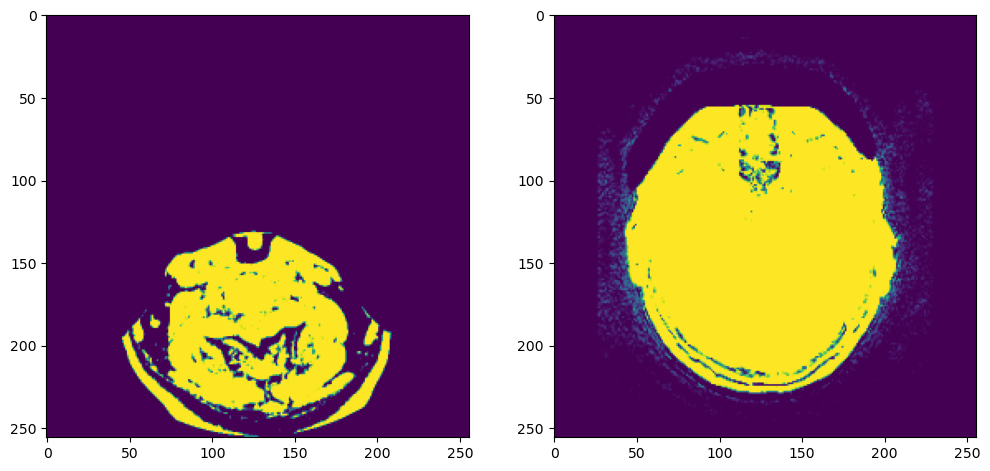

In [277]:
_, ax = plt.subplots(1, 2, figsize=(12, 6))

# 元の画像とどのくらい違いがあるかを確認

# 元の画像(.npy)
src = np.load(f'../series_npy/{CFG.image_size}/1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557/00012.npy')
print(np.unique(src))
ax[0].imshow(src)

# Datasetから取り出した画像
images, _ = train_dataset[0]
image = images[8].numpy()  # shape: [H, W]

# 0-1のfloatなら0-255に変換
if image.max() <= 1.0:
    image = (image * 255).astype(np.uint8)
else:
    image = image.astype(np.uint8)

ax[1].imshow(image)


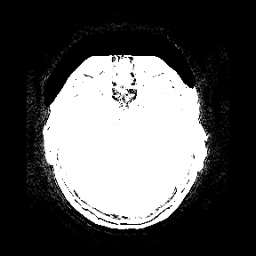

In [278]:
pil_image = Image.fromarray(image)
display(pil_image)


# 7. Functions

In [279]:
# count execution time for one epoch
def count_time(start:float) -> str:
    
    elapsed_time = time.time() - start
    hour = str(int(elapsed_time // 3600)).zfill(2)
    minute = str(int((elapsed_time % 3600) // 60)).zfill(2)
    second = str(int((elapsed_time % 3600 % 60))).zfill(2)
    
    elapsed_time = f'{hour}:{minute}:{second}'
    
    return elapsed_time


In [280]:
# to save model, optimizer, scheduler
def save_checkpoint(model, optimizer, scheduler, path=""):
    
    path = path.replace('\\', '/')
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
    }
    torch.save(checkpoint, path)

# to load model, optimizer, scheduler
def load_checkpoint(model, optimizer, scheduler, path=""):
    
    path = path.replace('\\', '/')
    
    checkpoint = torch.load(path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler is not None and checkpoint['scheduler_state_dict'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    return model, optimizer, scheduler


In [281]:
# to log loss, metrics, time to W&B
def log_by_wandb(epoch, losses, time):
    
    epoch_data = {
        'epoch': epoch,
        'loss': losses,
        'time': time
    }
    
    wandb.log(epoch_data)


In [282]:
# to log checkpoint
def log_artifact(run=run, artifact=artifact, checkpoint_path=""):
    
    artifact.add_file(checkpoint_path)
    run.log_artifact(artifact)
    
    print('Artifact was logged to W&B')


# 7. Training

In [283]:
def train_one_epoch(epoch: int) -> Tuple[float, float]:
    
    print(f'----- Epoch {epoch + 1} -----')
    
    # Training
    train_losses = []
    model.train()
    
    for images, labels in tqdm(train_dataloader):    
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type=CFG.device):
            print('train:', images.shape)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
    
    mean_train_loss = np.mean(train_losses)
    print(f'Mean Train Loss: {mean_train_loss:.4f}')
    
    # Validation
    val_losses = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            with autocast(device_type=CFG.device):
                print('val:', images.shape)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
        
    mean_val_loss = np.mean(val_losses)
    print(f'Mean Validation Loss: {mean_val_loss:.4f}')
        
    scheduler.step()
        
    return mean_train_loss, mean_val_loss


In [284]:
def main():
    
    os.makedirs(CFG.save_dir, exist_ok=True)
    best_val_loss = np.inf
    
    for epoch in range(CFG.num_epochs):
        
        # Train & Validation
        start_time = time.time()
        train_loss, val_loss = train_one_epoch(epoch)
        elapsed_time = count_time(start_time)
        print(f'Elapsed time: {elapsed_time}')
        
        # Log to W&B
        if CFG.use_wandb:
            losses = {
                'train_loss': train_loss,
                'val_loss': val_loss
            }
            log_by_wandb(epoch + 1, losses, elapsed_time)
        
        # Save all checkpoints
        checkpoint_path = os.path.join(
            CFG.save_dir,
            f'checkpoint_epoch{epoch + 1}_{date_time}.pth'
        )
        save_checkpoint(model, optimizer, scheduler, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')
        
        # Save best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_checkpoint_path = os.path.join(
                CFG.save_dir,
                f'best_checkpoint_{date_time}.pth'
            )
            save_checkpoint(model, optimizer, scheduler, best_checkpoint_path)
            print(f'Best checkpoint updated at {best_checkpoint_path}')
    
    # Log artifact to W&B
    if CFG.use_wandb:
        log_artifact(run, artifact, best_checkpoint_path)


In [285]:
main()


----- Epoch 1 -----


  0%|          | 0/1 [00:00<?, ?it/s]

1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.6804


  0%|          | 0/1 [00:00<?, ?it/s]

1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.1000
Elapsed time: 00:00:02
Checkpoint saved at ../results/swin-s-base-512x16\checkpoint_epoch1_2025-09-24_01-06-47.pth
Best checkpoint updated at ../results/swin-s-base-512x16\best_checkpoint_2025-09-24_01-06-47.pth
----- Epoch 2 -----


  0%|          | 0/1 [00:00<?, ?it/s]

1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.0923


  0%|          | 0/1 [00:00<?, ?it/s]

1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.0187
Elapsed time: 00:00:00
Checkpoint saved at ../results/swin-s-base-512x16\checkpoint_epoch2_2025-09-24_01-06-47.pth
Best checkpoint updated at ../results/swin-s-base-512x16\best_checkpoint_2025-09-24_01-06-47.pth
----- Epoch 3 -----


  0%|          | 0/1 [00:00<?, ?it/s]

1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.0178


  0%|          | 0/1 [00:00<?, ?it/s]

1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.0135
Elapsed time: 00:00:00


RuntimeError: [enforce fail at inline_container.cc:626] . unexpected pos 340875840 vs 340875728

In [ ]:
datetime


<module 'datetime' from 'c:\\Users\\emanon\\anaconda3\\envs\\Kaggle\\Lib\\datetime.py'>

stacked: (16, 256, 256)  
transformed: torch.Size([256, 16, 256])  
permuted: torch.Size([256, 256, 16])  
train: torch.Size([1, 256, 256, 16])  

stacked: (16, 256, 256)  
transformed: torch.Size([256, 16, 256])  
permuted: torch.Size([256, 256, 16])  
train: torch.Size([1, 256, 256, 16])  


stacked: (16, 256, 256)  
transformed: torch.Size([256, 256, 16])  
permuted: torch.Size([16, 256, 256])  
train: torch.Size([1, 16, 256, 256])  

stacked: (16, 256, 256)  
transformed: torch.Size([256, 16, 256])  
permuted: torch.Size([256, 256, 16])  
train: torch.Size([1, 256, 256, 16])  